In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from sklearn import preprocessing

torch.set_num_threads(8)
os.environ['MKL_NUM_THREADS'] = "8"
os.environ['OMP_NUM_THREADS'] = "8"
OMP_NUM_THREADS=8
MKL_NUM_THREADS=8

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

In [2]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))

testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainset.train_data.shape

In [6]:
gpu=False

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 30 epochs"""
    lr = 0.05 * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def train_eval(net,n_epochs=50):
    losses=[]
    if gpu==True:
        criterion = nn.CrossEntropyLoss().cuda()
    else:
        criterion = nn.CrossEntropyLoss()
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            if gpu==True:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            # forward + backward + optimize
            outputs, fcw = net(inputs)

            #optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9)
            
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), 
                                  lr=0.05, momentum=0.9, weight_decay=5e-4)
            adjust_learning_rate(optimizer, epoch)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            l1 = torch.abs(fcw).sum()
            #print('CRIT', criterion(outputs, labels))
            #print('L1', l1)

            loss = criterion(outputs, labels) #+ 0.001*l1
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                losses.append(running_loss/ 2000)
                running_loss = 0.0
                #print('L1 = %s'%l1)
        
    print('Finished Training')
    plt.plot(losses)

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in testloader:
        images, labels = data
        if gpu==True:                                 
            outputs,_ = net(Variable(images).cuda())
            _, predicted = torch.max(outputs.data.cpu(), 1)
        else:
            outputs,_ = net(Variable(images))
            _, predicted = torch.max(outputs.data, 1)                               
        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    print np.sum(class_correct)/np.sum(class_total)

## 3 layer randCNN 

In [35]:
class rand_Net3(nn.Module):
    def __init__(self):
        super(rand_Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3,padding=1)
        self.conv3 = nn.Conv2d(128, 512, 3,padding=1)
        self.fc = nn.Linear(4096*2, 10)
        for p in self.conv1.parameters():
            p.requires_grad = False
        for p in self.conv2.parameters():
            p.requires_grad = False
        for p in self.conv3.parameters():
            p.requires_grad = False

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x, self.fc.weight

/homes/cdt17/yuki/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 1.985
[2,  2000] loss: 1.732
[3,  2000] loss: 1.642
[4,  2000] loss: 1.598
[5,  2000] loss: 1.560
[6,  2000] loss: 1.532
[7,  2000] loss: 1.524
[8,  2000] loss: 1.497
[9,  2000] loss: 1.485
[10,  2000] loss: 1.476
[11,  2000] loss: 1.470
[12,  2000] loss: 1.464
[13,  2000] loss: 1.459
[14,  2000] loss: 1.448
[15,  2000] loss: 1.441
[16,  2000] loss: 1.441
[17,  2000] loss: 1.433
[18,  2000] loss: 1.431
[19,  2000] loss: 1.439
[20,  2000] loss: 1.426
[21,  2000] loss: 1.431
[22,  2000] loss: 1.423
[23,  2000] loss: 1.414
[24,  2000] loss: 1.419
[25,  2000] loss: 1.424
[26,  2000] loss: 1.425
[27,  2000] loss: 1.426
[28,  2000] loss: 1.409
[29,  2000] loss: 1.423
[30,  2000] loss: 1.423
[31,  2000] loss: 1.318
[32,  2000] loss: 1.308
[33,  2000] loss: 1.318
[34,  2000] loss: 1.323
[35,  2000] loss: 1.317
[36,  2000] loss: 1.314
[37,  2000] loss: 1.321
[38,  2000] loss: 1.321
[39,  2000] loss: 1.321
[40,  2000] loss: 1.315
[41,  2000] loss: 1.317
[42,  2000] loss: 1.318
[

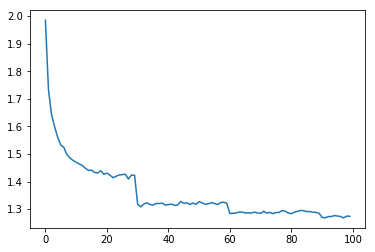

In [46]:
net3 = rand_Net3()
net3.cuda()
train_eval(net3,n_epochs=100)

In [ ]:
class rand_Net3u(nn.Module):
    def __init__(self):
        super(rand_Net3u, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 3,padding=1)
        self.conv2 = nn.Conv2d(256, 256, 3,padding=1)
        self.conv3 = nn.Conv2d(256, 256, 3,padding=1)
        self.fc = nn.Linear(4096, 10)
        for p in self.conv1.parameters():
            p.requires_grad = False
        for p in self.conv2.parameters():
            p.requires_grad = False
        for p in self.conv3.parameters():
            p.requires_grad = False

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x, self.fc.weight

In [ ]:
net3u = rand_Net3u()
net3u.cuda()
train_eval(net3u,n_epochs=130)

## with different random init

In [29]:
class rand_Net3_lap(nn.Module):
    def __init__(self):
        super(rand_Net3_lap, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3,padding=1)
        self.conv3 = nn.Conv2d(128, 512, 3,padding=1)
        self.fc = nn.Linear(4096*2, 10)
        for p in self.conv1.parameters():
            p.requires_grad = False
        for p in self.conv2.parameters():
            p.requires_grad = False
        for p in self.conv3.parameters():
            p.requires_grad = False
            
        for k in range(self.conv1.weight.data.shape[1]):
            self.conv1.weight.data[k,0,:,:] = torch.FloatTensor(np.matmul(np.random.laplace(0,1./3,(3,1)),np.random.laplace(0,1./3,(1,3))))
        for k in range(self.conv2.weight.data.shape[1]):
            self.conv2.weight.data[k,0,:,:] = torch.FloatTensor(np.matmul(np.random.laplace(0,1./3,(3,1)),np.random.laplace(0,1./3,(1,3))))
        for k in range(self.conv3.weight.data.shape[1]):
            self.conv3.weight.data[k,0,:,:] = torch.FloatTensor(np.matmul(np.random.laplace(0,1./3,(3,1)),np.random.laplace(0,1./3,(1,3))))
        

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x, self.fc.weight

In [ ]:
net3l = rand_Net3_lap()
net3l.cuda()
train_eval(net3l,n_epochs=200)

/homes/cdt17/yuki/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 2.120
[2,  2000] loss: 1.803
[3,  2000] loss: 1.709
[4,  2000] loss: 1.659
[5,  2000] loss: 1.622
[6,  2000] loss: 1.594
[7,  2000] loss: 1.566
[8,  2000] loss: 1.558
[9,  2000] loss: 1.542
[10,  2000] loss: 1.535
[11,  2000] loss: 1.530
[12,  2000] loss: 1.509
[13,  2000] loss: 1.513
[14,  2000] loss: 1.498
[15,  2000] loss: 1.501
[16,  2000] loss: 1.489
[17,  2000] loss: 1.497
[18,  2000] loss: 1.490
[19,  2000] loss: 1.490
[20,  2000] loss: 1.473
[21,  2000] loss: 1.482
[22,  2000] loss: 1.490
[23,  2000] loss: 1.470
[24,  2000] loss: 1.490
[25,  2000] loss: 1.480
[26,  2000] loss: 1.470
[27,  2000] loss: 1.475
[28,  2000] loss: 1.469
[29,  2000] loss: 1.470
[30,  2000] loss: 1.471
[31,  2000] loss: 1.325
[32,  2000] loss: 1.318
[33,  2000] loss: 1.314
[34,  2000] loss: 1.317
[35,  2000] loss: 1.325
[36,  2000] loss: 1.320
[37,  2000] loss: 1.324
[38,  2000] loss: 1.324
[39,  2000] loss: 1.324
[40,  2000] loss: 1.320
[41,  2000] loss: 1.320
[42,  2000] loss: 1.327
[

In [45]:
import numpy as np
H = np.matmul(np.random.laplace(0,1./3,(3,1)),np.random.laplace(0,1./3,(1,3)))
H = np.matmul(np.random.choice([-1.,0,1.],(3,1)),np.random.choice([-1.,0,1.],(1,3)))
print H
#print H/np.max((np.ones(3),np.sqrt(H.sum(0))))



print preprocessing.normalize(H, norm='l2', axis=0)



[[ 0.  0.  0.]
 [ 1. -1. -1.]
 [ 0.  0.  0.]]
[[ 0.  0.  0.]
 [ 1. -1. -1.]
 [ 0.  0.  0.]]


In [7]:
class rand_Net3_haar(nn.Module):
    def __init__(self):
        super(rand_Net3_haar, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 3,padding=1)
        self.conv2 = nn.Conv2d(256, 256, 3,padding=1)
        self.conv3 = nn.Conv2d(256, 256, 3,padding=1)
        self.fc = nn.Linear(4096, 10)
        for p in self.conv1.parameters():
            p.requires_grad = False
        for p in self.conv2.parameters():
            p.requires_grad = False
        for p in self.conv3.parameters():
            p.requires_grad = False
            
        for k in range(self.conv1.weight.data.shape[1]):
            H = np.matmul(np.random.choice([-1.,0,1.],(3,1)),np.random.choice([-1.,0,1.],(1,3)))
            #self.conv1.weight.data[k,0,:,:] = torch.FloatTensor(preprocessing.normalize(H, norm='l2', axis=0))
        for k in range(self.conv2.weight.data.shape[1]):
            H = np.matmul(np.random.choice([-1.,0,1.],(3,1)),np.random.choice([-1.,0,1.],(1,3)))
            #self.conv2.weight.data[k,0,:,:] = torch.FloatTensor(preprocessing.normalize(H, norm='l2', axis=0))
        for k in range(self.conv3.weight.data.shape[1]):
            H = np.matmul(np.random.choice([-1.,0,1.],(3,1)),np.random.choice([-1.,0,1.],(1,3)))
            #self.conv3.weight.data[k,0,:,:] = torch.FloatTensor(preprocessing.normalize(H, norm='l2', axis=0))
        

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x, self.fc.weight

In [8]:
net3h = rand_Net3_haar()
train_eval(net3h,n_epochs=50)

/Users/yuki/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 1.909
[2,  2000] loss: 1.687
[3,  2000] loss: 1.617
[4,  2000] loss: 1.568
[5,  2000] loss: 1.541
[6,  2000] loss: 1.516
[7,  2000] loss: 1.500
[8,  2000] loss: 1.484
[9,  2000] loss: 1.473
[10,  2000] loss: 1.466


Process Process-25:
Process Process-26:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/yuki/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/yuki/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/Users/yuki/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Users/yuki/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/Users/yuki/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
  File "/Users/yuki/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  File "/Users/yuki/anaconda2/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/Users/yuki/a

KeyboardInterrupt: 

## 4-layer

In [50]:
class rand_Net4(nn.Module):
    def __init__(self):
        super(rand_Net4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32*2, 3,padding=1)
        self.conv2 = nn.Conv2d(32*2, 64*2, 3,padding=1)
        self.conv3 = nn.Conv2d(64*2, 128*2, 3,padding=1)
        self.conv4 = nn.Conv2d(128*2, 512*2, 3,padding=1)

        self.fc = nn.Linear(2048*2, 10)
        for p in self.conv1.parameters():
            p.requires_grad = False
        for p in self.conv2.parameters():
            p.requires_grad = False
        for p in self.conv3.parameters():
            p.requires_grad = False
        for p in self.conv4.parameters():
            p.requires_grad = False
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv4(x)),kernel_size=2, stride=2)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x, self.fc.weight

[1,  2000] loss: 2.099
[2,  2000] loss: 1.878
[3,  2000] loss: 1.801
[4,  2000] loss: 1.762
[5,  2000] loss: 1.728
[6,  2000] loss: 1.706
[7,  2000] loss: 1.688
[8,  2000] loss: 1.683
[9,  2000] loss: 1.669
[10,  2000] loss: 1.660
[11,  2000] loss: 1.652
[12,  2000] loss: 1.644
[13,  2000] loss: 1.637
[14,  2000] loss: 1.629
[15,  2000] loss: 1.626
[16,  2000] loss: 1.626
[17,  2000] loss: 1.621
[18,  2000] loss: 1.619
[19,  2000] loss: 1.615
[20,  2000] loss: 1.613
[21,  2000] loss: 1.617
[22,  2000] loss: 1.611
[23,  2000] loss: 1.611
[24,  2000] loss: 1.603
[25,  2000] loss: 1.606
[26,  2000] loss: 1.608
[27,  2000] loss: 1.604
[28,  2000] loss: 1.604
[29,  2000] loss: 1.606
[30,  2000] loss: 1.604
[31,  2000] loss: 1.592
[32,  2000] loss: 1.594
[33,  2000] loss: 1.594
[34,  2000] loss: 1.586
[35,  2000] loss: 1.595
[36,  2000] loss: 1.591
[37,  2000] loss: 1.590
[38,  2000] loss: 1.590
[39,  2000] loss: 1.595
[40,  2000] loss: 1.590
[41,  2000] loss: 1.593
[42,  2000] loss: 1.589
[

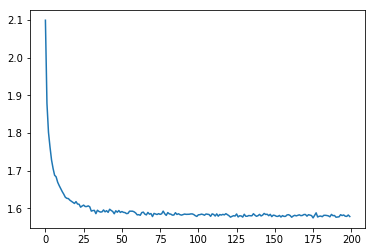

In [51]:
net4 = rand_Net4()
net4.cuda()
train_eval(net4,n_epochs=200)

# try deeper network

In [47]:
#vgg11 [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
   
class rand_vgg11(nn.Module):
    def __init__(self):
        super(rand_vgg11, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,padding=1)
        
        self.conv2 = nn.Conv2d(64, 128*2, 3,padding=1)
        
        self.conv3 = nn.Conv2d(128*2, 256*2, 3,padding=1)
        self.conv4 = nn.Conv2d(256*2, 256*2, 3,padding=1)
                
        self.conv5 = nn.Conv2d(256*2, 512*4, 3,padding=1)
        self.conv6 = nn.Conv2d(512*4, 512*4, 3,padding=1)
        
        self.conv7 = nn.Conv2d(512*4, 512*4, 3,padding=1)
        self.conv8 = nn.Conv2d(512*4, 512*4, 3,padding=1)

        self.fc = nn.Linear(512*4, 10)
        for p in self.conv1.parameters():
            p.requires_grad = False
        for p in self.conv2.parameters():
            p.requires_grad = False
        for p in self.conv3.parameters():
            p.requires_grad = False
        for p in self.conv4.parameters():
            p.requires_grad = False
        for p in self.conv5.parameters():
            p.requires_grad = False
        for p in self.conv6.parameters():
            p.requires_grad = False
        for p in self.conv7.parameters():
            p.requires_grad = False
        for p in self.conv8.parameters():
            p.requires_grad = False
            
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2, stride=2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)),kernel_size=2, stride=2)
        
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(F.relu(self.conv6(x)),kernel_size=2, stride=2)
        
        x = F.relu(self.conv7(x))
        x = F.max_pool2d(F.relu(self.conv8(x)),kernel_size=2, stride=2)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x, self.fc.weight

In [ ]:
netvgg11 = rand_vgg11()
criterion = nn.CrossEntropyLoss() 
losses=[]
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # forward + backward + optimize
        outputs, fcw = netvgg11(inputs)
                
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, netvgg11.parameters()), lr=0.001, momentum=0.9)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #l1 = torch.abs(fcw).sum()
        #print('CRIT', criterion(outputs, labels))
        #print('L1', l1)
        
        loss = criterion(outputs, labels) #+ 0.001*l1
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    losses.append(loss.data[0])
plt.plot(losses)
print('Finished Training')

In [32]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs,_ = netvgg11(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(8):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print np.sum(class_correct)/np.sum(class_total)

Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer : 100 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %
0.1


## Compare to pixel by pixel Lasso classification

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=7000,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=500,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [19]:
from sklearn import linear_model,metrics,preprocessing
from sklearn.ensemble import RandomForestClassifier

print('compute purely on pixels')
for ty,data in enumerate(trainloader):
    images, labels = data
    for alpha in [1]:#np.logspace(0,3,10):
        print alpha
        reg = linear_model.LogisticRegression(penalty='l1',solver ='saga',C = alpha,n_jobs=6,max_iter=3)
        rf = RandomForestClassifier(n_estimators = 300,n_jobs=6)
        reg.fit(images[:,:,:,:].numpy().reshape(7000,-1) , labels) 
        rf.fit(images[:,:,:,:].numpy().reshape(7000,-1) , labels) 
    for mod in [reg,rf]:
        print ("-----")
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        for a,data in enumerate(testloader):
            imagesp, labelsp = data
            predicted = mod.predict(imagesp[:,:,:,:].numpy().reshape(500,-1))
            c = (predicted == labelsp).squeeze()
            for i in range(500):
                label = labelsp[i]
                class_correct[label] += c[i]
                class_total[label] += 1
            if a>=4:
                break 
        for i in range(10):
            print('Accuracy of %5s : %2d %%' % (
                classes[i], 100 * class_correct[i] / class_total[i]))
        print np.sum(class_correct)/np.sum(class_total)
    break



compute purely on pixels
1
-----
Accuracy of plane : 43 %
Accuracy of   car : 43 %
Accuracy of  bird : 26 %
Accuracy of   cat : 17 %
Accuracy of  deer : 28 %
Accuracy of   dog : 27 %
Accuracy of  frog : 48 %
Accuracy of horse : 48 %
Accuracy of  ship : 53 %
Accuracy of truck : 41 %
0.3804
-----
Accuracy of plane : 46 %
Accuracy of   car : 46 %
Accuracy of  bird : 33 %
Accuracy of   cat : 21 %
Accuracy of  deer : 32 %
Accuracy of   dog : 36 %
Accuracy of  frog : 51 %
Accuracy of horse : 45 %
Accuracy of  ship : 66 %
Accuracy of truck : 51 %
0.4368
